In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import Polygon, Point


In [2]:
otaz = pd.read_csv('Data_with_TAZ/merged_data_otaz.csv')
dtaz = pd.read_csv('Data_with_TAZ/merged_data_dtaz.csv')
points = pd.read_csv('Data_with_TAZ/points_lon_lat.csv')

In [3]:
# Example path to a shapefile containing county polygons
shapefile_path = 'shape/sfbay-tazs-epsg-26910.shp'

# Load the shapefile
counties_gdf = gpd.read_file(shapefile_path)

# Filter or process the GeoDataFrame as needed, for example, to select specific counties


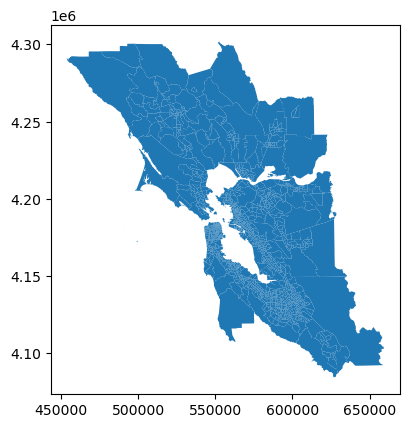

In [4]:
# Plot the GeoDataFrame
counties_gdf.plot()

# Show the plot
plt.show()


In [5]:
# Count the size of every county polygon
counties_gdf['area'] = counties_gdf['geometry'].area


In [6]:
# Example DataFrame for points
# Replace these with your actual longitude and latitude columns
longitude = list(dtaz['lon'])
latitude = list(dtaz['lat'])

# Create GeoDataFrame for points
gdf_points_dtaz = gpd.GeoDataFrame(geometry=[Point(xy) for xy in zip(longitude, latitude)])

# Assuming you already have a GeoDataFrame for polygons called gdf_polygons
# If not, you need to create it from your polygon data

In [7]:
# Transform both geometries to WGS 84 (EPSG:4326)
counties_gdf = counties_gdf.to_crs("EPSG:4326")


In [8]:
# Assuming gdf_points and gdf_polygons are already defined
# Example spatial join - points within polygons
joined = gpd.sjoin(gdf_points_dtaz, counties_gdf, how='inner', op='within')

# Count the number of points within each polygon
points_count = joined.groupby(joined.index_right).size()

# Create a new DataFrame from the counts (to ensure correct merging with gdf_polygons)
counts_df = points_count.reset_index(name='points_count')

# Rename columns if necessary to match your gdf_polygons
# counts_df.rename(columns={'index_right': 'your_polygon_id_column'}, inplace=True)

# Merge the counts back into the original polygons GeoDataFrame
gdf_polygons = counties_gdf.merge(counts_df, left_index=True, right_on='index_right', how='left')

# Fill NaN values with 0 if there are polygons with no points within them
gdf_polygons['points_count'].fillna(0, inplace=True)

# add density column 
gdf_polygons['density'] = gdf_polygons['points_count'] / gdf_polygons['area']


# Now, gdf_polygons contains a new column 'points_count' with the number of points within each polygon


/Applications/Anaconda/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/var/folders/bd/fq3z0ph13ms3dnbk1fhkkpkw0000gn/T/ipykernel_2208/994978498.py:3: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  joined = gpd.sjoin(gdf_points_dtaz, counties_gdf, how='inner', op='within')


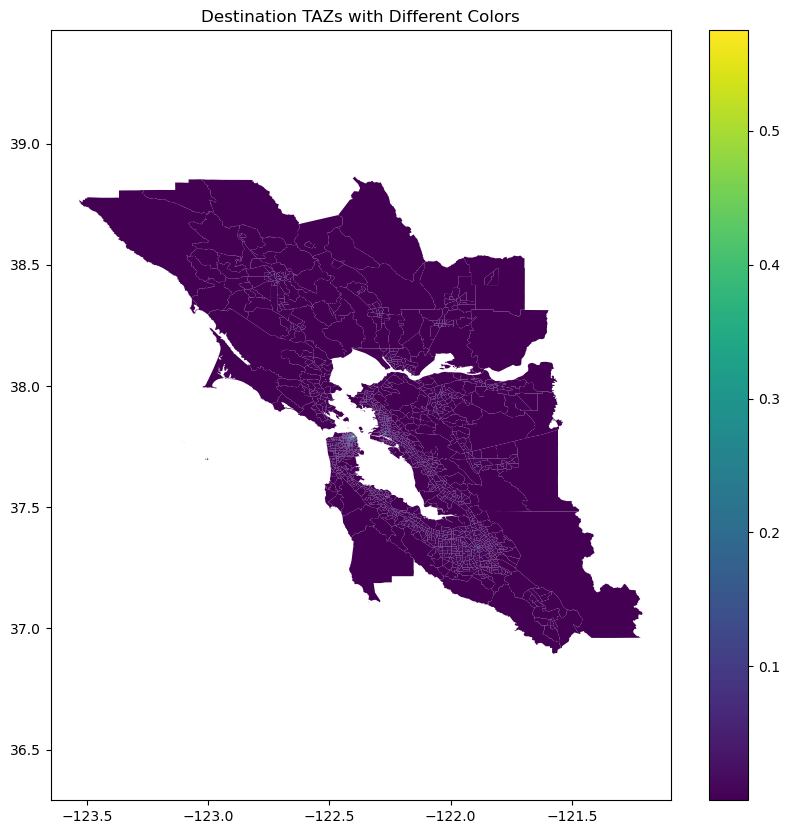

In [9]:
# Plot the GeoDataFrame with different colors for each row based on 'objectid'
gdf_polygons.plot(column='density', figsize=(10, 10), legend=True)

# Add title
plt.title('Destination TAZs with Different Colors')

# Optional: Set axes to be equal to keep the aspect ratio square
plt.axis('equal')

# Save figure
plt.savefig('destination_figure.jpeg')

# Show the plot
plt.show()


In [10]:
# Calculate the hour of departure and add it as a new column
dtaz['hour'] = (dtaz['deptm'] / 60).astype(int)


In [11]:
# Assuming longitude and latitude lists are correctly obtained from otaz DataFrame
gdf_points_dtaz = gpd.GeoDataFrame(dtaz, geometry=[Point(xy) for xy in zip(dtaz['lon'], dtaz['lat'])], crs="EPSG:4326")


In [12]:
import matplotlib.pyplot as plt
import geopandas as gpd
import imageio

def generate_frame(hour, output_path):
    fig, ax = plt.subplots(figsize=(10, 10))
    plt.axis('equal')
    ax.set_aspect('equal')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    
    # Filter points for the current hour
    points_current_hour = gdf_points_dtaz[gdf_points_dtaz['hour'] == hour]
    
    # Perform a spatial join between points and polygons to find points within each polygon
    joined = gpd.sjoin(points_current_hour, counties_gdf, how='inner', op='within')
    
    # Count the number of points in each polygon for the current hour
    points_count = joined.groupby('taz1454').size().reset_index(name='points_count')
    
    # Merge this count back into the original polygons GeoDataFrame
    counties_with_counts = counties_gdf.merge(points_count, on='taz1454', how='left').fillna(0)

    counties_with_counts['density'] = counties_with_counts['points_count'] / counties_with_counts['area']
    
    # Plotting the heatmap based on 'points_count' with a fixed color bar range
    counties_with_counts.plot(column='density', ax=ax, legend=True, cmap='viridis', vmin=0, vmax=0.075,
                              legend_kwds={'label': "Density per TAZ", 'orientation': "horizontal"})
    
    # Set title dynamically with the hour
    ax.set_title(f'Hour: {hour} TAZs Density Heatmap - Destination', fontsize=15)
    
    # Save the figure
    plt.savefig(output_path)
    plt.close(fig)

# Assuming gdf_points_otaz and counties_gdf are already defined and prepared
# Directory where the images will be saved and list to store image filenames
output_dir = 'taz_density_heatmap_pictures_fixed'
image_files = []

# Generate and save a frame for each hour
for hour in sorted(gdf_points_dtaz['hour'].unique()):
    output_path = f'{output_dir}/frame_{hour}.png'
    generate_frame(hour, output_path)
    image_files.append(output_path)

# Create a GIF from the saved images using imageio
gif_path = 'taz_demsity_heatmap_animation_fixed.gif'
duration_per_frame = 1000 / 2  # 500ms per frame for 2fps

with imageio.get_writer(gif_path, mode='I', duration=duration_per_frame) as writer:
    for filename in image_files:
        image = imageio.imread(filename)
        writer.append_data(image)


/Applications/Anaconda/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3505: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Applications/Anaconda/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3505: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Applications/Anaconda/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3505: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Applications/Anaconda/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3505: FutureWarning: The `op` parameter i

In [13]:
import matplotlib.pyplot as plt
import geopandas as gpd
import imageio

# Assuming gdf_points_otaz and counties_gdf are already defined and in the correct CRS

def generate_frame(hour, output_path):
    fig, ax = plt.subplots(figsize=(10, 10))
    plt.axis('equal')  # Ensure the plot maintains a square aspect ratio
    ax.set_aspect('equal')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    
    # Filter points for the current hour
    points_current_hour = gdf_points_dtaz[gdf_points_dtaz['hour'] == hour]
    
    # Perform a spatial join between points and polygons to find points within each polygon
    joined = gpd.sjoin(points_current_hour, counties_gdf, how='inner', op='within')
    
    # Count the number of points in each polygon for the current hour
    points_count = joined.groupby('taz1454').size().reset_index(name='points_count')
    
    # Merge this count back into the original polygons GeoDataFrame
    counties_with_counts = counties_gdf.merge(points_count, on='taz1454', how='left').fillna(0)

    counties_with_counts['density'] = counties_with_counts['points_count'] / counties_with_counts['area']
    
    # Plotting the heatmap based on 'points_count'
    counties_with_counts.plot(column='density', ax=ax, legend=True, cmap='viridis',
                              legend_kwds={'label': "Density per TAZ", 'orientation': "horizontal"})
    
    # Set title dynamically with the hour
    ax.set_title(f'Hour: {hour} TAZs Density Heatmap - Destination', fontsize=15)
    
    # Save the figure
    plt.savefig(output_path)
    plt.close(fig)  # Close the figure to free up memory

# Directory where the images will be saved
output_dir = 'taz_density_heatmap_pictures'
image_files = []

# Generate and save a frame for each hour
for hour in sorted(gdf_points_dtaz['hour'].unique()):
    output_path = f'{output_dir}/frame_{hour}.png'
    generate_frame(hour, output_path)
    image_files.append(output_path)


/Applications/Anaconda/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3505: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Applications/Anaconda/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3505: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Applications/Anaconda/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3505: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Applications/Anaconda/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3505: FutureWarning: The `op` parameter i

In [14]:
# Create a GIF from the saved images
gif_path = 'taz_density_heatmap_animation.gif'
# Calculate duration based on desired fps
fps = 2
duration_per_frame = 1000 / fps  # Duration in milliseconds

with imageio.get_writer(gif_path, mode='I', duration=duration_per_frame) as writer:
    for filename in image_files:
        image = imageio.imread(filename)
        writer.append_data(image)


/var/folders/bd/fq3z0ph13ms3dnbk1fhkkpkw0000gn/T/ipykernel_2208/1119619043.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
